In [2]:
# Import Libraries
# for text preprocessing
import re
import spacy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
# import numpy for matrix operation
import numpy as np
# Importing Gensim

import gensim
from gensim import corpora
import pandas as pd

In [3]:
dataframe = pd.read_csv("data/Facebook_Consolidated.csv")
dataframe

,0
0,Why nowadays every thing seem to be increasin...
1,I will have to disagree.. we’re not that high!!
2,"Wag po tayong mag-alala. Naniniwala po ako, is..."
3,Ok lang yang lahat naman nang bansa ganyan. Sa...
4,Sama-sama tayong BABAON muli.
...,...
1367,Di lang sa pinas kahit kami d2 sa abroad lahat...
1368,Unity lng
1369,Dipa ramdam hahaha kami lng ata ang walang pak...
1370,GLOBALLY kasi Yan. Di lang jan sa Pinas!


In [4]:
corpus = list(dataframe["0"])

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# stop words
stop = set(stopwords.words('english'))

In [7]:
# nltk.download()

In [8]:
# Apply Preprocessing on the Corpus

# stop words
stop = set(stopwords.words('english'))

# punctuation
exclude = set(string.punctuation)

# lemmatization
lemma = WordNetLemmatizer()

# One function for all the steps:
def clean(doc):
    
    # convert text into lower case + split into words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
   
    # remove any stop words present
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    
   
    # remove punctuations + normalize the text
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())  
    return normalized

# clean data stored in a new list
clean_corpus = [clean(doc).split() for doc in corpus]

In [9]:
# where every unique term is assigned an index.
dict_ = corpora.Dictionary(clean_corpus)

In [10]:
# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [dict_.doc2bow(i) for i in clean_corpus]

In [11]:
# Creating the object for LDA model using gensim library

Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(corpus=doc_term_matrix, num_topics=6, id2word = dict_, passes=20, random_state=20, eval_every=None)

# Prints the topics with the indexes: 0,1,2 :
ldamodel.print_topics()
# we need to manually check whethere the topics are different from one another or not
print(ldamodel.print_topics(num_topics=6, num_words=5))

# num_topics mean: how many topics want to extract
# num_words: the number of words that want per topic


[(0, '0.017*"inflation" + 0.009*"u" + 0.008*"filipino" + 0.007*"government" + 0.007*"time"'), (1, '0.035*"na" + 0.033*"unity" + 0.030*"ang" + 0.029*"lang" + 0.025*"ng"'), (2, '0.019*"sa" + 0.013*"high" + 0.013*"ang" + 0.011*"mga" + 0.011*"disagree"'), (3, '0.033*"ang" + 0.032*"sa" + 0.023*"ng" + 0.022*"yan" + 0.020*"nyo"'), (4, '0.048*"sa" + 0.040*"ang" + 0.037*"na" + 0.037*"ng" + 0.028*"mga"'), (5, '0.014*"inflation" + 0.012*"high" + 0.011*"may" + 0.009*"were" + 0.007*"step"')]


In [12]:
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(model=ldamodel, texts=clean_corpus, dictionary=dict_, coherence="c_v")

coherence_model.get_coherence()



0.5009660178099257

In [13]:
# NOTE: Gensim’s perplexity value is in logarithmic form. To compare with sklearn’s perplexity value np.exp(-1 *gensim.log_perplexity) is used

print(ldamodel.log_perplexity(doc_term_matrix ))
print(np.exp(-1 * ldamodel.log_perplexity(doc_term_matrix )))


-7.299619222592069
1479.6814359721454


In [14]:
# Train model with increasing number of topics

limit=32; start=2; step=4


def train_model_with_diff_topicN(dictionary, corpus, texts, limit, start=2, step=3):
   model_list = []
   for num_topics in range(start, limit, step):
      model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix, num_topics=num_topics, id2word = dict_, passes=10, random_state=0, eval_every=None)
      model_list.append(model)
   return model_list

all_model_list = train_model_with_diff_topicN(dictionary=dict_, corpus=doc_term_matrix, texts=clean_corpus, limit=limit,start=start, step=step )

In [15]:
# A method for computing different coherence values(c_v, c_npmi, u_mass) of all models with different number of topics. 

from gensim.models import CoherenceModel

def compute_coherence_values(model_list,dictionary,  texts):
   all_coherence_values ={}
   coherence_types = ["c_v", "c_npmi", "u_mass"]
   
   for coherence_type in coherence_types:
      coherence_values = []
      for model in model_list:
         
         coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
         coherence_values.append(coherence_model.get_coherence())
      all_coherence_values[coherence_type] = coherence_values
      
   return all_coherence_values

In [16]:
# Computes for the perplexity values of models with different number of topics

def compute_perplexity_values(model_list, doc_term_matrix):
   perplexity_values = []
   for model in model_list:
      perplexity_values.append(np.exp(-1 * model.log_perplexity(doc_term_matrix )))
     
   return perplexity_values

In [17]:
# A method for computing the pairwise Jaccard Similarity of topN topics from a model. 
from itertools import combinations


def pairwise_jaccard_diversity(topics, topk=10):
    '''
    compute the average pairwise jaccard distance between the topics
 
    Parameters
    ----------
    topics: a list of lists of words
    topk: top k words on which the topic diversity
          will be computed
   
    Returns
    -------
    pjd: average pairwise jaccard distance
    '''
    dist = 0
    count = 0
    for list1, list2 in combinations(topics, 2):
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist/count


In [19]:
# Computes for the jaccard similarity values of models with different number of topics

def compute_jaccard_similarity_values(model_list):
   jaccard_scores = []
   for model in model_list:
      all_topics = []
      for i in range(len(model.show_topics())):
         topic = [x[0] for x in model.show_topic(i, topn=6)]
         all_topics.append(topic)
      jaccard_scores.append(pairwise_jaccard_diversity(all_topics, 6))
   
   return jaccard_scores

In [32]:
# A method for computing different coherence values(c_v, c_npmi, u_mass) of all models with different number of topics. 

from gensim.models import CoherenceModel

def compute_coherence_values(model, dictionary,  texts):
   all_coherence_values ={}
   coherence_types = ["c_v", "c_npmi", "u_mass"]
   
   
   coherence_values = []
   for coherence_type in coherence_types:
      coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_type)
      coherence_values.append(coherence_model.get_coherence())
      
   return coherence_values

In [45]:
import concurrent.futures as cf
import itertools

workers = 8
 
all_coherence_values = []
with cf.ThreadPoolExecutor(max_workers=workers) as executor:
    #for n in executor.map(_findmatch, numberlist):
    for n in executor.map(compute_coherence_values, all_model_list, itertools.repeat(dict_), itertools.repeat(clean_corpus)):
        all_coherence_values.append(n)

3
3
3
3
3
3
3
3


In [43]:
all_coherence_values_temp = {"c_v":[], "c_npmi":[], "u_mass":[]}
coherence_types = ["c_v", "c_npmi", "u_mass"]
for coherence_values in all_coherence_values:
   for index,coherence_type in enumerate(coherence_types):
      all_coherence_values_temp[coherence_type].append(coherence_values[index])

In [51]:
type(all_coherence_values_temp)

dict

In [36]:
all_perplexity_values= compute_perplexity_values(all_model_list, doc_term_matrix=doc_term_matrix)
all_jaccard_values = compute_jaccard_similarity_values(all_model_list)

In [52]:
all_coherence_values = all_coherence_values_temp

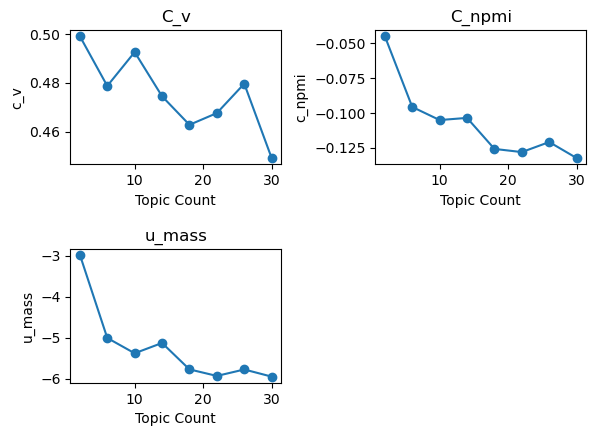

In [53]:
import matplotlib.pyplot as plt

limit=32; start=2; step=4
x = range(start, limit, step)

coherence_types = ["c_v", "c_npmi", "u_mass"]

fig, axs = plt.subplots(2,2 )
axs[0,0].plot(np.array(x), np.array(all_coherence_values["c_v"]), marker='o', label="c_v")
axs[0, 0].set_title("C_v")
axs[0,1].plot(x, all_coherence_values["c_npmi"], marker='o', label="c_npmi")
axs[0, 1].set_title("C_npmi")
axs[1,0].plot(x, all_coherence_values["u_mass"], marker='o', label="u_mass")
axs[1, 0].set_title("u_mass")
fig.delaxes(axs[1][1])
fig.tight_layout(pad=3.0)

for i,ax in enumerate(axs.flat):
   if i ==3:
      break
   ax.set(xlabel='Topic Count', ylabel=coherence_types[i])
   

# for coherence_type in coherence_types:
#    ax.plot(x, all_coherence_values[coherence_type], marker='o', label=coherence_type)


Text(0.5, 1.0, 'Perplexity Scores')

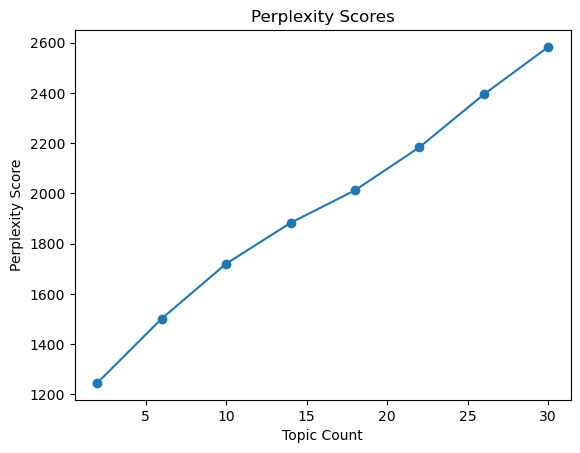

In [54]:
plt.plot(x,  all_perplexity_values, marker='o')
plt.xlabel('Topic Count')
plt.ylabel('Perplexity Score')
plt.title('Perplexity Scores')


Text(0.5, 1.0, 'Average Pairwise Jaccard Similarity')

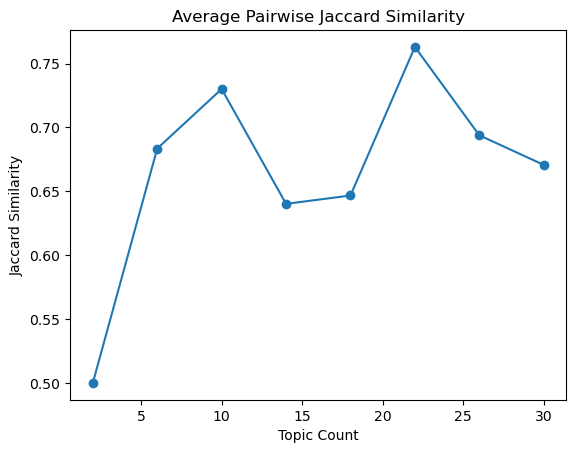

In [55]:
plt.plot(x,  all_jaccard_values , marker='o')
plt.xlabel('Topic Count')
plt.ylabel('Jaccard Similarity')
plt.title('Average Pairwise Jaccard Similarity')


In [ ]:
asdf

In [56]:
import pyLDAvis

import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
%matplotlib inline

gensimvis.prepare(ldamodel ,doc_term_matrix , dict_)


c:\Users\Arian\.conda\envs\data-mining\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Users\Arian\.conda\envs\data-mining\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.112797  0.008114       1        1  37.390323
3     -0.095342 -0.000266       2        1  21.599062
1     -0.112702 -0.068331       3        1  21.471087
2      0.016414  0.129478       4        1   9.044158
0      0.179973 -0.006298       5        1   5.262872
5      0.124454 -0.062697       6        1   5.232498, topic_info=           Term        Freq       Total Category  logprob  loglift
41        unity  159.000000  159.000000  Default  30.0000  30.0000
81    inflation   98.000000   98.000000  Default  29.0000  29.0000
71          yan  156.000000  156.000000  Default  28.0000  28.0000
35           sa  448.000000  448.000000  Default  27.0000  27.0000
18         high   36.000000   36.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
210       happy    2.465999   29.350722   Topic6  -5.7657   0.4736
276          di    2.433888   60.573416   Topic6  -5.7788  -0.2641
1020       sila    2.271429   35.107816   Topic6  -5.8479   0.2123
2103    unhappy    2.088595   18.993657   Topic6  -5.9318   0.7427
26         lang    2.097941  249.783249   Topic6  -5.9274  -1.8294

[417 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2101      3  0.804250      14m
2101      6  0.160850      14m
689       4  0.937895     2015
1430      4  0.937884   2years
988       1  0.114888       31
...     ...       ...      ...
456       3  0.435546     yung
456       5  0.011462     yung
456       6  0.011462     yung
3122      6  0.518895  yunitee
1457      4  0.937891       “i

[723 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1, 6])